In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from prophet import Prophet
import matplotlib.pyplot as plt
import joblib

Importing plotly failed. Interactive plots will not work.


In [2]:
# Function to load datasets
def load_data():
    sales_train_df = pd.read_csv('/Users/bananavodka/Projects/at2_mla/at2_mla/data/raw/sales_train.csv')
    calendar_df = pd.read_csv('/Users/bananavodka/Projects/at2_mla/at2_mla/data/raw/calendar.csv')
    calendar_events_df = pd.read_csv('/Users/bananavodka/Projects/at2_mla/at2_mla/data/raw/calendar_events.csv')
    sales_test_df = pd.read_csv('/Users/bananavodka/Projects/at2_mla/at2_mla/data/raw/sales_test.csv')
    items_weekly_sales_df = pd.read_csv('/Users/bananavodka/Projects/at2_mla/at2_mla/data/raw/items_weekly_sell_prices.csv')
    
    print("Datasets loaded successfully.")
    return sales_train_df, calendar_df, calendar_events_df, sales_test_df, items_weekly_sales_df

In [3]:
# Function to preprocess and merge datasets
def preprocess_data(sales_train_df, calendar_df, calendar_events_df, items_weekly_sales_df):
    # Melt sales data
    sales_train_melted = pd.melt(
        sales_train_df,
        id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
        var_name='d',
        value_name='sales'
    )
    
    # Merge with calendar data
    sales_train_merged = pd.merge(sales_train_melted, calendar_df, how='left', on='d')

    # Merge with event data
    sales_train_with_events = pd.merge(sales_train_merged, calendar_events_df, how='left', on='date')

    # Merge with item prices
    sales_train_with_prices = pd.merge(sales_train_with_events, items_weekly_sales_df, how='left', on=['item_id', 'store_id', 'wm_yr_wk'])

    # Fill missing event names and types
    sales_train_with_prices['event_name'].fillna('No Event', inplace=True)
    sales_train_with_prices['event_type'].fillna('None', inplace=True)

    # Forward-fill missing prices
    sales_train_with_prices['sell_price'].fillna(method='ffill', inplace=True)
    sales_train_with_prices['sell_price'].fillna(
        sales_train_with_prices.groupby('item_id')['sell_price'].transform('mean'), 
        inplace=True
    )

    print("Data preprocessed successfully.")
    return sales_train_with_prices

In [4]:
# Function to create features
def create_features(sales_train_with_prices):
    # Convert 'date' to datetime
    sales_train_with_prices['date'] = pd.to_datetime(sales_train_with_prices['date'])

    # Create date-based features
    sales_train_with_prices['day'] = sales_train_with_prices['date'].dt.day
    sales_train_with_prices['month'] = sales_train_with_prices['date'].dt.month
    sales_train_with_prices['weekday'] = sales_train_with_prices['date'].dt.weekday

    # Label encoding
    encoder_store = LabelEncoder()
    encoder_item = LabelEncoder()
    sales_train_with_prices['store_id'] = encoder_store.fit_transform(sales_train_with_prices['store_id'])
    sales_train_with_prices['item_id'] = encoder_item.fit_transform(sales_train_with_prices['item_id'])

    # Initialize label encoders for event names and types
    le_event_name = LabelEncoder()
    le_event_type = LabelEncoder()
    sales_train_with_prices['event_name_encoded'] = le_event_name.fit_transform(sales_train_with_prices['event_name'])
    sales_train_with_prices['event_type_encoded'] = le_event_type.fit_transform(sales_train_with_prices['event_type'])

    print("Features created successfully.")
    return sales_train_with_prices, encoder_store, encoder_item, le_event_name, le_event_type

In [5]:
# Function to aggregate daily sales across all stores and items for Prophet
def aggregate_sales(sales_train_with_prices):
    # Aggregate total daily sales
    sales_data = sales_train_with_prices.groupby('date').agg({'sales': 'sum'}).reset_index()

    # Rename columns to match Prophet's expected format
    sales_data.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)
    
    print("Sales data aggregated successfully.")
    return sales_data

In [6]:
# Function to train Prophet model
def train_prophet(sales_data):
    # Initialize Prophet model
    prophet_model = Prophet()

    # Fit the model on the aggregated sales data
    prophet_model.fit(sales_data)

    print("Prophet model trained successfully.")
    return prophet_model

In [7]:
# Function to make future predictions and plot the forecast using Prophet
def make_forecast(prophet_model, periods=7):
    # Create a dataframe for the next `periods` days
    future_dates = prophet_model.make_future_dataframe(periods=periods)

    # Make predictions
    forecast = prophet_model.predict(future_dates)

    # Plot the forecast using Prophet's built-in plot method
    fig = prophet_model.plot(forecast)
    
    # Show the plot
    plt.show()

    # Return the forecasted values
    print("Forecast generated and plotted successfully.")
    return forecast

Datasets loaded successfully.
Data preprocessed successfully.
Features created successfully.
Sales data aggregated successfully.


15:25:10 - cmdstanpy - INFO - Chain [1] start processing
15:25:11 - cmdstanpy - INFO - Chain [1] done processing


Prophet model trained successfully.


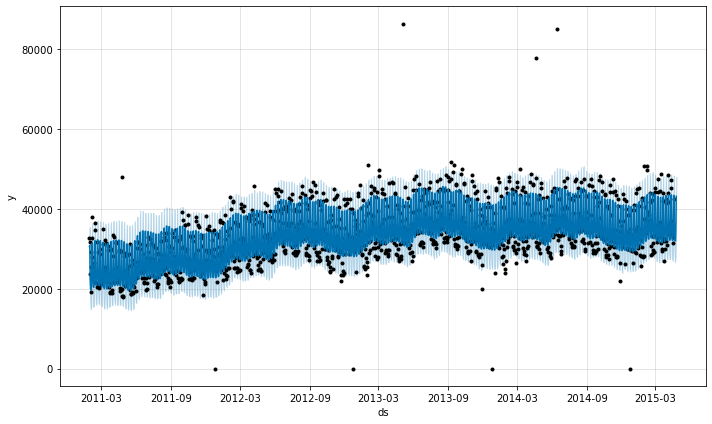

Forecast generated and plotted successfully.
             ds          yhat    yhat_lower    yhat_upper
1541 2015-04-19  43406.839464  38388.593292  48039.169527
1542 2015-04-20  34755.405185  29633.130013  39444.067132
1543 2015-04-21  32354.027674  27404.505361  37183.561481
1544 2015-04-22  31946.385414  26593.682912  36263.521767
1545 2015-04-23  32017.665288  27450.433695  36859.524362
1546 2015-04-24  36124.125229  31358.820457  41040.959960
1547 2015-04-25  43152.995340  38530.039900  48021.927489


In [8]:
# Main function to execute the entire pipeline
def main():
    # Load datasets
    sales_train_df, calendar_df, calendar_events_df, sales_test_df, items_weekly_sales_df = load_data()

    # Preprocess data
    sales_train_with_prices = preprocess_data(sales_train_df, calendar_df, calendar_events_df, items_weekly_sales_df)

    # Create features
    sales_train_with_prices, encoder_store, encoder_item, le_event_name, le_event_type = create_features(sales_train_with_prices)

    # Aggregate daily sales for Prophet
    sales_data = aggregate_sales(sales_train_with_prices)

    # Train Prophet model
    prophet_model = train_prophet(sales_data)

    # Make forecast for the next 7 days
    forecast = make_forecast(prophet_model, periods=7)

    # Display forecasted values
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7))

if __name__ == "__main__":
    main()